In [1]:
import torch

from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

#torch.set_default_device(device)

In [3]:
torch.get_default_device()

device(type='cpu')

In [4]:
device

device(type='mps')

In [5]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [6]:
[c for c in unicodedata.normalize('NFD', 'Ślusàrski')]

['S', '́', 'l', 'u', 's', 'a', '̀', 'r', 's', 'k', 'i']

In [7]:
[c for c in unicodedata.normalize('NFD', 'おはようございます')]

['お', 'は', 'よ', 'う', 'こ', '゙', 'さ', '゙', 'い', 'ま', 'す']

In [8]:
[c for c in unicodedata.normalize('NFKD', 'おはようございます')]

['お', 'は', 'よ', 'う', 'こ', '゙', 'さ', '゙', 'い', 'ま', 'す']

In [9]:
[c for c in unicodedata.normalize('NFKC', 'おはようございます')]

['お', 'は', 'よ', 'う', 'ご', 'ざ', 'い', 'ま', 'す']

In [10]:
[c for c in unicodedata.normalize('NFC', 'おはようございます')]

['お', 'は', 'よ', 'う', 'ご', 'ざ', 'い', 'ま', 'す']

In [11]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [12]:
allowed_characters, len(allowed_characters)

("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'_", 58)

In [13]:
print (f"The letter 'a' becomes {lineToTensor('a')}") #notice that the first position in the tensor = 1
print (f"The name 'ab' becomes {lineToTensor('ab')}")

The letter 'a' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])
The name 'ab' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])


In [14]:
from io import open
import glob
import os
import time

from torch.utils.data import Dataset

class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in tqdm(text_files):
            # Separates into <language> <.txt>.
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The name as is.
        data_item = self.data[idx]
        # The name of the file (w/o extension).
        data_label = self.labels[idx]
        # Name in tensor form.
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [15]:
alldata = NamesDataset("data/names")

  0%|          | 0/18 [00:00<?, ?it/s]

In [16]:
print(f"loaded {len(alldata):_} items of data")
print(f"example = {alldata[0]}")

loaded 20_074 items of data
example = (tensor([12]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]]), 'Czech', 'Abl')


In [17]:
_label_tensor, _data_tensor, _data_label, _data_item = alldata[0]

In [18]:
_data_item

'Abl'

In [19]:
_data_label

'Czech'

In [20]:
_label_tensor

tensor([12])

In [21]:
_data_tensor, _data_tensor.shape # 58 is the vocab size.

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]]]),
 torch.Size([3, 1, 58]))

In [22]:
alldata.labels_tensors[0], alldata.labels[0]

(tensor([12]), 'Czech')

In [23]:
# Find what "8" actually means in a robust way.
alldata.labels_uniq, alldata.labels_uniq[ _label_tensor ]

(['Scottish',
  'Japanese',
  'Italian',
  'Vietnamese',
  'German',
  'Portuguese',
  'Polish',
  'Irish',
  'Greek',
  'Spanish',
  'French',
  'Korean',
  'Czech',
  'Dutch',
  'English',
  'Chinese',
  'Arabic',
  'Russian'],
 'Czech')

In [24]:
# Get indices of the 1s (argmax returns the index of the maximum value).
# The last dim of the tensor, the one of size vocab (58) is where we the one we care
# to find the 1 in if we want to convert the encodings back into characters.
indices = torch.argmax(_data_tensor, dim=2)
indices

tensor([[26],
        [ 1],
        [11]])

In [25]:
''.join(
    [ allowed_characters[char_idx] for char_idx in indices ]
)

'Abl'

In [26]:
train_set, test_set = torch.utils.data.random_split(
    alldata,
    [.85, .15],
    #generator=torch.Generator(device=device).manual_seed(2024),
    generator=torch.Generator().manual_seed(2024),
)

In [27]:
print(f"train examples = {len(train_set):_}, validation examples = {len(test_set):_}")

train examples = 17_063, validation examples = 3_011


# The RNN

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [29]:
# 8 input nodes, 128 hidden nodes, and 18 outputs.
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
rnn

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [40]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    #print(f'{top_n=} - {top_i=}')
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

In [31]:
_input = lineToTensor('Albert')
_output = rnn(_input)

_input, _output, label_from_output(_output, alldata.labels_uniq)

top_n=tensor([[-2.7261]], grad_fn=<TopkBackward0>) - top_i=tensor([[14]])


(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

# Training

In [32]:
import random
import numpy as np

def train(
    rnn,
    training_data,
    n_epoch = 10,
    n_batch_size = 64,
    report_every = 50,
    learning_rate = 0.2,
    criterion = nn.NLLLoss(),
):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
    
    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in tqdm(range(1, n_epoch + 1)):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]

                # Move tensors to the same device as the model
                label_tensor = label_tensor.to(device)
                text_tensor = text_tensor.to(device)
                
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
             tqdm.write(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [33]:
start = time.time()

rnn = rnn.to(device)
all_losses = train(rnn, train_set, n_epoch=5, learning_rate=0.15, report_every=1)

end = time.time()

training on data set with n = 17063


  0%|          | 0/5 [00:00<?, ?it/s]

1 (20%): 	 average batch loss = 1.3988251796411324
2 (40%): 	 average batch loss = 1.1019664020983726
3 (60%): 	 average batch loss = 1.0096315920008203
4 (80%): 	 average batch loss = 0.9483666266472509
5 (100%): 	 average batch loss = 0.8913452899063026


In [34]:
print(f"training took {end-start}s")

training took 484.4691970348358s


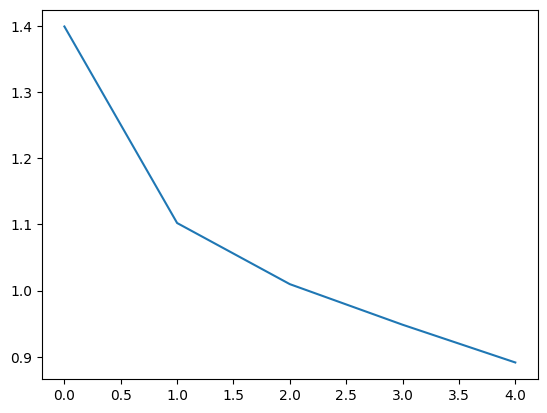

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

In [38]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]

            # Move tensors to the same device as the model
            text_tensor = text_tensor.to(device)

            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

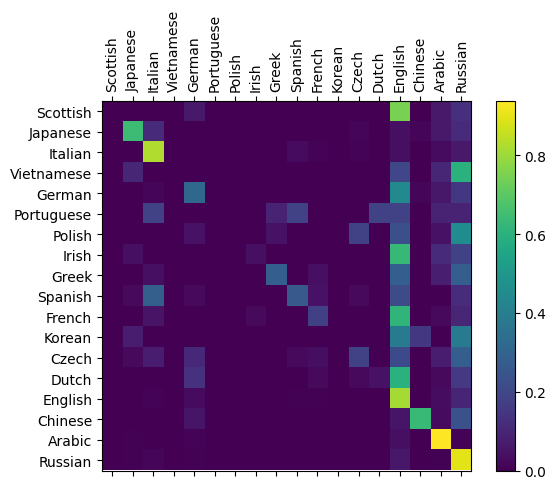

In [41]:
evaluate(rnn, test_set, classes=alldata.labels_uniq)